## Plasmonic sensor

* The notebook simulates the optical responses of plasmonic sensor: reflectance, transmittance and absorbance.[Jon Schlipf and Inga A. Fischer,Opt.Express.2021](https://opg.optica.org/oe/fulltext.cfm?uri=oe-29-22-36201&id=461916) 
* We apply bottom-up construction and vector-based computation to enhance RCWA simulation, which can accelerate **2X faster**. The conventional RCWA simulation is given in the [Example 2](Ex2_plasmonic_sensor_RT.ipynb)


<img src="./Images/Plasmonic_sensor.png" width="200" height="200" align="left">

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import time
import os
import sys
path_parent=os.path.dirname(os.getcwd())
sys.path.insert(0,path_parent)
from src import Scattering
from src import ReadData 
from src import Geo
from src import Computation
from src import Plot
from src.Tools import vec2m

## Optical index

In [2]:
path_optical_index=path_parent+'/dataNK/'
path_Si=path_optical_index+ 'c-Si_HJY_Modif.txt'
path_SiO2=path_optical_index+ 'SiO2_HJY_Modif.txt'
path_Al=path_optical_index+ 'Al_McPeak.txt'
path_Ge=path_optical_index+ 'Ge_Nunley.txt'

h=4.135667516*1e-15;#[eV s]      
c=299792458         #[m/s]

Si_wl, Si_nk=ReadData.read_nk(path_Si)
Si_wl=h*c/Si_wl*10**9      #eV to nm

SiO2_wl, SiO2_nk=ReadData.read_nk(path_SiO2)
SiO2_wl=h*c/SiO2_wl*10**9  #eV to nm

Al_wl, Al_nk=ReadData.read_nk(path_Al)
Al_wl=Al_wl*1000  # um to nm

Ge_wl, Ge_nk=ReadData.read_nk(path_Ge)
Ge_wl=Ge_wl*1000 # um to nm

In [3]:
wavelength_range=np.linspace(1000,1600,81) 
e_Si=ReadData.Interpolate_Optical_Index(wavelength_range,Si_wl, Si_nk)
e_SiO2=ReadData.Interpolate_Optical_Index(wavelength_range,SiO2_wl, SiO2_nk)
e_Al=ReadData.Interpolate_Optical_Index(wavelength_range,Al_wl, Al_nk)
e_Ge=ReadData.Interpolate_Optical_Index(wavelength_range,Ge_wl, Ge_nk)

#reflectance and transmission
u_ref=1; u_trn=1;  e_ref=1.321**2 #water
e_trn=np.copy(e_Si);  e_air=1

## Input parameters

In [4]:
#Angle
AOI_d = 0
Azimuth_d=0
AOI_r=np.radians(AOI_d) 
Azimuth_r=np.radians(Azimuth_d) 

#geometry
Lx_cell=950; Ly_cell=950  #pitch in nm
reso=1
Diameter=500
Thickness=[100,50,50,1000] # only one layer

# diffraction order in x-y direction
mx=10;my=10       

## Parameters in RCWA

In [5]:
Thickness_Sim=[100,50,50,1000] 
NL=len(Thickness_Sim)

#Geometry
Geo.reso, Geo.Lx_cell, Geo.Ly_cell= reso, Lx_cell, Ly_cell
Geo.mx, Geo.my= mx, my
#Scattering
Scattering.AOI_r, Scattering.Azimuth_r =AOI_r, Azimuth_r
Scattering.Meshgrid()

In [6]:
#layer materials
e_m=[e_Al,e_SiO2,e_Si,e_Ge]   

Geometry=[]
for lth in range(NL):
    layer_lth={}      
    if lth <1:
        layer_lth['Shape']=Geo.Circle
        layer_lth['e_base']=e_m[lth]
        layer_lth['e_grt']=1
        layer_lth['Critical']=[Diameter]
        layer_lth['Center']=[Lx_cell/2,Ly_cell/2]
    else:
        layer_lth['Shape']='Homo'
        layer_lth['e_base']=e_m[lth]   
   
    Geometry.append(layer_lth)  

## Visualization

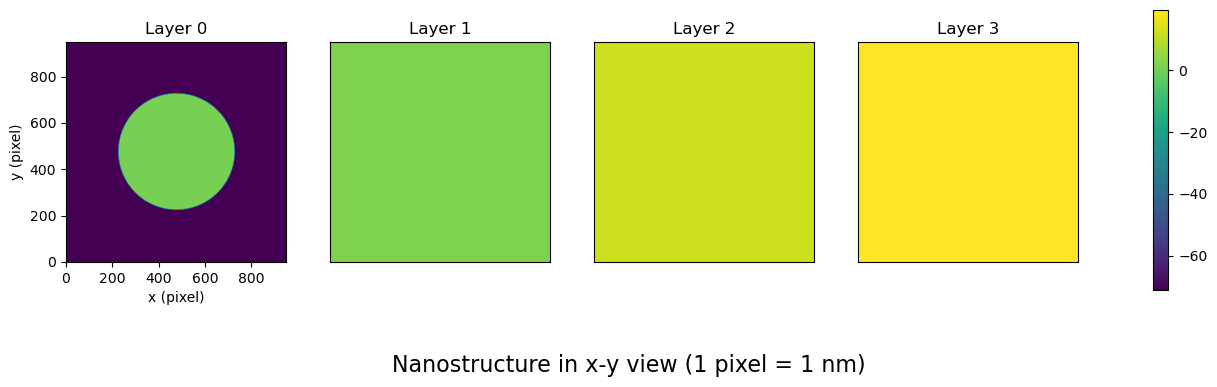

In [8]:
geo_e=np.array([Plot.Geo_viz(layer_lth) for layer_lth in Geometry])
Plot.Viz_xy(geo_e,pos_layer=[0,1,2,3])

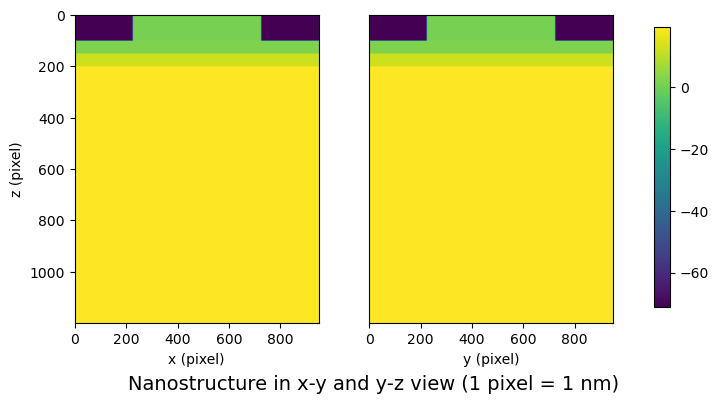

In [8]:
Plot.Viz_z(geo_e,Thickness_Sim)

# Simulation

In [9]:
t0=time.time()
ERC_CONV=[Geo.CONV_layer(wavelength_range,layer_lth) for layer_lth in Geometry]
t_conv=time.time()-t0
print(t_conv)

10.231070280075073


In [10]:
t0=time.time()
Ref=[];  Trn=[]

unit=Scattering.unit
unit_mat=Scattering.unit_mat
for wth in range(len(wavelength_range)):    
    
    #Update: Kx,Ky,kz_inc,Vg,Vzr,Vzt  
    Scattering.KxKy_Component(wavelength_range[wth],e_ref,e_trn[wth])      
    # S-layer       
    S_layer=[Scattering.S_Layer(Thickness_Sim[lth],ERC_CONV[lth][wth],based_homo='vector') for lth in range(NL) ] 
    
    # Combine for S_global: bottom up: Initial S_global is S_trn
    S_trn=Scattering.Trn_medium(based='vector')      
    S_global_11=S_trn[0];S_global_21=S_trn[2]  # bottom-up: need half for R,T    
    
    for lth in range(1,NL)[::-1]:#3 bottom homogeneous layer         
        S_global_11,S_global_21=Computation.redheffer_global_bottom_up_plane(unit,S_layer[lth],[S_global_11,S_global_21],Sim='half')    
        
    lth=0# last top grating layer    
    S_global_11=vec2m(S_global_11);S_global_21=vec2m(S_global_21) # covert vector into matrix to connect gratings
    S_global_11,S_global_21=Computation.redheffer_global_bottom_up(unit_mat,S_layer[lth],[S_global_11,S_global_21],Sim='half')
    
    S_ref=Scattering.Ref_medium()  # if reflection medium is air, we do not need to do this step   
    S_global_11,S_global_21=Computation.redheffer_global_bottom_up(unit_mat,S_ref, [S_global_11,S_global_21],Sim='half')     
   
    # compute  R and T     
    rx,ry= Scattering.Optical_Response(S_global_11,'pte')  
    tx,ty= Scattering.Optical_Response(S_global_21,'pte')      
    
    R=Scattering.Reflectance(rx,ry)        
    Ref.append(np.sum(R))        
    
    T=Scattering.Transmittance(tx,ty)      
    Trn.append(np.sum(T))     

Ref=np.array(Ref)
Trn=np.array(Trn) 

print(time.time() -t0)    

246.70690774917603


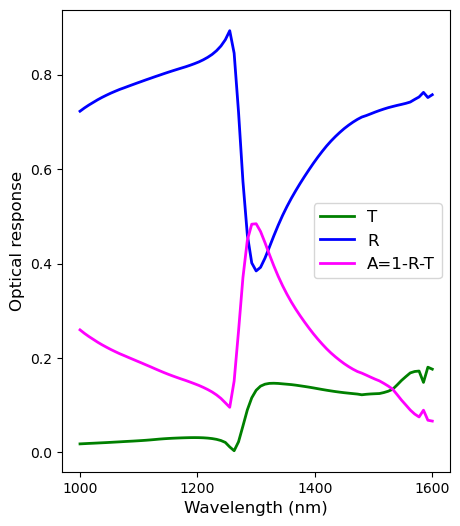

In [11]:
# View spectrum
fig_size=(5,6)
fig, ax = plt.subplots(nrows=1, ncols=1,figsize=fig_size)
plt.rcParams['xtick.labelsize'] = 14 
plt.rcParams['ytick.labelsize'] = 14 

ax.plot(wavelength_range,Trn,c='green',lw=2,label='T')
ax.plot(wavelength_range,Ref,c='blue',lw=2,label='R')
ax.plot(wavelength_range,1-Ref-Trn,c='magenta',lw=2,label='A=1-R-T')
ax.legend(loc="upper right")

ax.legend(prop=dict(size=12))

ax.set_xlabel('Wavelength (nm)',fontsize = 12.0)
ax.set_ylabel('Optical response',fontsize = 12.0)
plt.show()